In [1]:
# Application of Deep Learning to Algorithmic Trading (2017)
# 퀀트 전략을 위한 인공지능 트레이딩 (김태헌, 신준호 지음, 한빛미디어)
# 8.2 RNN을 활용한 주가 방향성 분류 예측 (pp. 285~312)

import pandas as pd
import pandas_datareader as pdr
import numpy as np

np.random.seed(111)


intc_df = pdr.get_data_yahoo('INTC', start = '2000-01-01')     # 인텔 주가

# 시장 상황을 파악할 수 있는 시장 인덱스 데이터
sox_df = pdr.get_data_yahoo('^SOX', start = '2000-01-01')      # 반도체 지수
vix_df = pdr.get_data_yahoo('^VIX', start = '2000-01-01')      # 변동성 지수 : S&P 500 지수 옵션 가격의 향후 30일 동안 변동성
snp500_df = pdr.get_data_yahoo('^GSPC', start = '2000-01-01')  # S&P500 지수

# intc_df.to_csv('intc.csv')
# sox_df.to_csv('sox_df.csv')
# vix_df.to_csv('vix_df.csv')
# snp500_df.to_csv('snp500.csv')

df = pd.read_csv('intc.csv', index_col='Date', parse_dates=True)

In [2]:
# TA-Lib 활용(맥 M1에서 설치 완료 - 220221)
# brew install ta-lib
# export TA_INCLUDE_PATH="$(brew --prefix ta-lib)/include"
# export TA_LIBRARY_PATH="$(brew --prefix ta-lib)/lib"
# pip install ta-lib
# "python3.8 -m pip install ta-lib" (220221, 이 코드 실행 시 정상 설치 완료)
# 실습 환경 : Macbook air M1, tf24_Py38 (miniconda)

# 기술적 분석을 수행하는 시스템 트레이딩에서 사용하는 라이브러리
# 주요 기능으로 MACD, RSI, 확률, 볼린저 밴드 등과 같은 138개 지표를 사용할 수 있도록
# 내장 함수를 지원한다.
# 윈도우 버전에서 설치 시 비공식적인 윈도우용 바이러니 파일을 이용해서 설치해야 하는 단점이 있다.

import talib

In [3]:
## 데이터 불러오기 ##
df['next_rtn'] = df['Close'] / df['Open'] - 1  
# 다음날 수익률을 예측하도록 문제를 정의한다.
# 다음날 시가와 종가간의 수정 종가를 하루 미뤄줌으로써 레이블링 데이터를 만든다? / 당일 수익률? (220221)

df['log_return'] = np.log(1 + df['Adj Close'].pct_change())

## 이동 평균(Moving Average) ##

# 이동 평균선(5일, 10일)
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA10'] = talib.SMA(df['Close'], timeperiod=10)

# 이동 표준 편차(5일, 10일)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1), timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1), timeperiod=10)


## MACD(Moving Average Convergence & Divergence) : 모멘텀 트렌드 지표 ##
macd, macdsignal, macdhidst = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd

## 모멘텀 지표 ##
# CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)

## 변동성 지표 ##
# ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

## 볼린저 밴드 ##
upper, middle, lower = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

## MTM1 MTM3 ##
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

## Rate of Change 지표 ##
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

## Williams' %R ##
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,MACD,CCI,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,25.017096,-0.017897,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,26.441755,0.044849,0.055385,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.34375,NaN,NaN,NaN
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,25.207056,-0.029261,-0.047820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,25.416004,0.007530,0.008255,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,23.934357,-0.036697,-0.060064,41.4625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN


In [5]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,MACD,CCI,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,48.459999,47.189999,47.700001,48.439999,35857500.0,48.439999,0.015514,0.017913,48.484000,48.521,...,-1.060437,-53.798543,1.388346,53.121848,49.5545,45.987151,0.859997,-0.420002,-2.495978,-43.085155
2022-02-16,48.490002,47.599998,48.060001,48.230000,26022900.0,48.230000,0.003537,-0.004345,48.148000,48.393,...,-1.030095,-38.251383,1.352750,52.364068,49.2850,46.205932,-0.209999,0.599998,-2.605010,-47.411464
2022-02-17,48.259998,47.380001,47.860001,47.570000,32030600.0,47.570000,-0.006059,-0.013779,47.890000,48.322,...,-1.047233,-94.228908,1.318982,51.951325,49.0615,46.171675,-0.660000,-0.010002,-4.535425,-83.916119
2022-02-18,46.209999,44.509998,46.189999,45.040001,76481700.0,45.040001,-0.024897,-0.054651,47.372000,48.025,...,-1.250549,-288.500152,1.443340,51.764578,48.7115,45.658422,-2.529999,-3.399998,-8.268834,-90.292998
2022-02-22,45.410000,43.849998,44.689999,44.689999,57079300.0,44.689999,0.000000,-0.007801,46.793999,47.676,...,-1.423512,-235.045096,1.451673,51.502651,48.3490,45.195349,-0.350002,-3.540001,-10.188906,-86.274513


In [6]:
# 가공된 데이터 프레임(df) 옆에 시장 지수 데이터 추가


# 데이터의 원본을 보존하기 위해 데이터를 복사해두는 것이라면,
# panda.DataFrame.copy()를 사용해야한다 (220221)

snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'}, inplace=True)

sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'}, inplace=True)

vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'}, inplace=True)

df = df.join(snp500_df, how='left')
df = df.join(sox_df, how='left')
df = df.join(vix_df, how='left')

df.tail()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,48.459999,47.189999,47.700001,48.439999,35857500.0,48.439999,0.015514,0.017913,48.484000,48.521,...,53.121848,49.5545,45.987151,0.859997,-0.420002,-2.495978,-43.085155,4471.069824,3554.449951,25.700001
2022-02-16,48.490002,47.599998,48.060001,48.230000,26022900.0,48.230000,0.003537,-0.004345,48.148000,48.393,...,52.364068,49.2850,46.205932,-0.209999,0.599998,-2.605010,-47.411464,4475.009766,3555.689941,24.290001
2022-02-17,48.259998,47.380001,47.860001,47.570000,32030600.0,47.570000,-0.006059,-0.013779,47.890000,48.322,...,51.951325,49.0615,46.171675,-0.660000,-0.010002,-4.535425,-83.916119,4380.259766,3422.600098,28.110001
2022-02-18,46.209999,44.509998,46.189999,45.040001,76481700.0,45.040001,-0.024897,-0.054651,47.372000,48.025,...,51.764578,48.7115,45.658422,-2.529999,-3.399998,-8.268834,-90.292998,4348.870117,3384.300049,27.750000
2022-02-22,45.410000,43.849998,44.689999,44.689999,57079300.0,44.689999,0.000000,-0.007801,46.793999,47.676,...,51.502651,48.3490,45.195349,-0.350002,-3.540001,-10.188906,-86.274513,4304.759766,3356.070068,28.809999


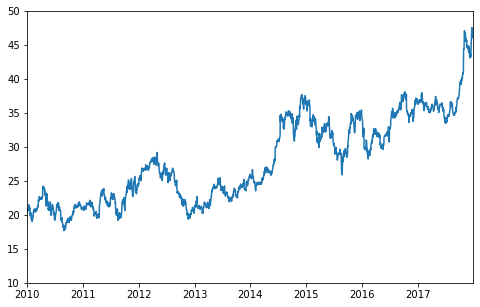

In [7]:
# 주가 변동 관찰 : 상승 구간 / 상승-하락 구간 / 변동 없는 구간 관찰 (220221)

import matplotlib.pyplot as plt
import datetime

plt.figure(figsize = (8, 5))
plt.plot(df['Close'])    # 종가(Close) 데이터 그래프로 확인

x_min = datetime.datetime(2010, 1, 1)
x_max = datetime.datetime(2017, 12, 30)
plt.xlim(x_min, x_max)
plt.ylim(10, 50)

plt.show()

In [8]:
# 분석을 위한 모든 변수가 포함된 데이터 프레임 완료 (220221)
## 데이터를 : 학습 - 검증 - 테스트 데이터 셋으로 구간(시간)별로 나눈다.

# 특성 목록
FEATURE_LIST_1 = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'log_return']
FEATURE_LIST_2 = ['RASD5', 'RASD10', 'ub', 'lb', 'CCI', 'ATR', 'MACD', 'MA5', 
                  'MA10', 'MTM1', 'MTM3', 'ROC', 'WPR']
FEATURE_LIST_3 = ['S&P500', 'SOX', 'VIX']
FEATURE_LIST_4 = ['next_rtn']

ALL_FEATURES = FEATURE_LIST_1 + FEATURE_LIST_2 + FEATURE_LIST_3 + FEATURE_LIST_4

# 데이터 셋의 기간 구분
# 2010~2017년 까지 3개의 구간으로 나누어 학습
# 1구간 : 주가가 상승하는 시기 / 2구간 : 하락+상승하는 시기 / 3구간 : 변동이 미미한 시기
PHASE_FLAG = '3'


if PHASE_FLAG == '1':
    train_from = '2010-01-04'
    train_to = '2012-01-01'
    
    val_from = '2012-01-01'
    val_to = '2012-04-01'
    
    test_from = '2012-04-01'
    test_to = '2012-07-01'
    
    
elif PHASE_FLAG == '2':
    train_from = '2010-07-01'
    train_to = '2014-07-01'
    
    val_from = '2014-07-01'
    val_to = '2014-10-01'
    
    test_from = '2014-10-01'
    test_to = '2015-01-01'
    
    
else :
    train_from = '2015-01-01'
    train_to = '2017-01-01'
    
    val_from = '2017-01-01'
    val_to = '2017-04-01'
    
    test_from = '2017-04-01'
    test_to = '2017-07-01'
    
    
# 학습 / 검증 / 테스트

# 데이터의 원본을 보존하기 위해 데이터를 복사해두는 것이라면,
# panda.DataFrame.copy()를 사용해야한다 (220221)

train_df = df.loc[train_from:train_to, ALL_FEATURES].copy()
val_df = df.loc[val_from:val_to, ALL_FEATURES].copy()
test_df = df.loc[test_from:test_to, ALL_FEATURES].copy()

In [9]:
# 정규화 하기 전, 훈련 셋의 데이터 분석

for x in ALL_FEATURES:
    print("columns : {}".format(x), "Max : {:.3f}".format(train_df[x].max()), 
          "min : {:.3f}".format(train_df[x].min()),
          "mean : {:.3f}".format(train_df[x].mean()), )

columns : Open Max : 38.250 min : 25.200 mean : 32.725
columns : High Max : 38.360 min : 27.150 mean : 33.035
columns : Low Max : 37.900 min : 24.870 mean : 32.436
columns : Adj Close Max : 33.033 min : 21.725 mean : 27.779
columns : Volume Max : 107402400.000 min : 5893800.000 mean : 26581258.333
columns : log_return Max : 0.062 min : -0.095 mean : 0.000
columns : RASD5 Max : 1.083 min : 0.075 mean : 0.365
columns : RASD10 Max : 0.916 min : 0.097 mean : 0.366
columns : ub Max : 39.179 min : 29.595 mean : 34.322
columns : lb Max : 36.737 min : 26.054 mean : 31.193
columns : CCI Max : 287.226 min : -315.499 mean : 4.797
columns : ATR Max : 0.986 min : 0.416 mean : 0.661
columns : MACD Max : 1.271 min : -1.220 mean : -0.004
columns : MA5 Max : 37.944 min : 26.702 mean : 32.755
columns : MA10 Max : 37.716 min : 27.437 mean : 32.756
columns : MTM1 Max : 1.920 min : -2.980 mean : -0.000
columns : MTM3 Max : 2.550 min : -3.150 mean : -0.001
columns : ROC Max : 28.179 min : -23.825 mean : 0.8

In [10]:
print("PHASE_FLAG: ", PHASE_FLAG)
print("train_df: ",len(train_df))
print("val_df: ",len(val_df))
print("test_df: ",len(test_df))

PHASE_FLAG:  3
train_df:  504
val_df:  62
test_df:  63


In [11]:
# 1구간 : 주가가 상승하는 시기 / 2구간 : 하락+상승하는 시기 / 3구간 : 변동이 미미한 시기
# 각 기간에 따라 예측 구간에서 그래프가 어떻게 나오는지 확인 필요
# 시계열이 짧을수록 딥러닝 모델을 활용한 전략의 성능이 좋지 못할 확률이 크다.

## 정규화 ##

# 학습을 진행할 때 각각의 특성 데이터가 상이한 범주를 가진다면
# 학습과정이 원활하지 않을 수 있다. ----> 정규화 필요

# 최소-최대 정규화 (min-max normalization)

from sklearn.preprocessing import MinMaxScaler

def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    
    for x in ALL_FEATURES:
        if x in FEATURE_LIST_4 :    # "next_rtn"컬럼 (당일 수익률?)에 값이 있다면 아래 코드 계속 진행 (220221) ??
            continue
            
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        
        # 스케일러 생성 및 훈련
        scaler = MinMaxScaler(feature_range=(0, 1))  # 0~1 사이의 값으로 정규화
        scaler = scaler.fit(values)
        
        # 데이터셋 정규화 및 출력
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)    # 정규화 처리되었다는 뜻으로 새롭게 컬럼 네이밍 처리
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized    # 새롭게 네이밍 처리된 컬럼으로 데이터 프레임 제작
    
    return sample_df, eng_list

In [12]:
# 학습 / 검증 / 테스트 : 정규화 처리

train_sample_df, eng_list = min_max_normal(train_df)
val_sample_df, eng_list = min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [13]:
print(eng_list)
print(len(eng_list))

['Open_normal', 'High_normal', 'Low_normal', 'Adj Close_normal', 'Volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal', 'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal', 'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal', 'WPR_normal', 'S&P500_normal', 'SOX_normal', 'VIX_normal']
22


In [14]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,29.850746,23605600.0,0.001927,0.360369,0.422398,37.964195,35.625804,...,0.611705,0.900729,0.926549,0.622449,0.408772,0.624169,0.427385,0.517622,0.335631,0.221242
2015-01-05,36.200001,36.450001,35.939999,29.514143,32785000.0,-0.011340,0.359143,0.416504,37.902114,35.536885,...,0.576726,0.872265,0.916140,0.524490,0.410527,0.552398,0.257261,0.432631,0.301055,0.293519
2015-01-06,36.080002,36.230000,35.259998,28.964088,30847600.0,-0.018813,0.429746,0.417354,37.855069,35.344930,...,0.526877,0.838463,0.905536,0.471428,0.375438,0.553077,0.008065,0.392034,0.262216,0.334238
2015-01-07,35.639999,36.070000,35.270000,29.571609,27725200.0,0.020758,0.449678,0.396641,37.788620,35.293380,...,0.511096,0.825298,0.893959,0.759184,0.492983,0.705804,0.306452,0.444650,0.279162,0.272820
2015-01-08,36.369999,37.000000,36.259998,30.121660,31765400.0,0.018430,0.450896,0.396890,37.770449,35.291550,...,0.519944,0.832414,0.886759,0.744898,0.682456,0.777092,0.576612,0.526523,0.330158,0.194774


In [15]:
# 정규화 실행 후, 훈련 셋의 데이터 분석

for x in eng_list:
    print("columns : {}".format(x), "Max : {:.3f}".format(train_sample_df[x].max()), 
          "min : {:.3f}".format(train_sample_df[x].min()),
          "mean : {:.3f}".format(train_sample_df[x].mean()), )

columns : Open_normal Max : 1.000 min : 0.000 mean : 0.577
columns : High_normal Max : 1.000 min : 0.000 mean : 0.525
columns : Low_normal Max : 1.000 min : 0.000 mean : 0.581
columns : Adj Close_normal Max : 1.000 min : 0.000 mean : 0.535
columns : Volume_normal Max : 1.000 min : 0.000 mean : 0.204
columns : log_return_normal Max : 1.000 min : 0.000 mean : 0.607
columns : RASD5_normal Max : 1.000 min : 0.000 mean : 0.288
columns : RASD10_normal Max : 1.000 min : 0.000 mean : 0.328
columns : ub_normal Max : 1.000 min : 0.000 mean : 0.493
columns : lb_normal Max : 1.000 min : 0.000 mean : 0.481
columns : CCI_normal Max : 1.000 min : 0.000 mean : 0.531
columns : ATR_normal Max : 1.000 min : 0.000 mean : 0.429
columns : MACD_normal Max : 1.000 min : 0.000 mean : 0.488
columns : MA5_normal Max : 1.000 min : 0.000 mean : 0.538
columns : MA10_normal Max : 1.000 min : 0.000 mean : 0.517
columns : MTM1_normal Max : 1.000 min : 0.000 mean : 0.608
columns : MTM3_normal Max : 1.000 min : 0.000 me

In [16]:
# 학습 데이터와 레이블 데이터 분할
# 목표 --> 다음 영업일 종가 예측
# 특성 데이터와 레이블 데이터를 구분

# LSTM 모델에 넣어줄 변수 데이터를 선택


def create_dateset_binary(data, feature_list, step, n):
    
    train_xdata = np.array(data[feature_list[0:n]])
    print(feature_list[0:n])
    m = np.arange(len(train_xdata) - step)         # 가장 마지막 단계 
    x, y = [], []
    
    for i in m :
        a = train_xdata[i:(i+step)]                 # step 만큼의 과거 기간을 입력으로 전달
        x.append(a)
    
    x_batch = np.reshape(np.array(x), (len(m), step, n))  # 신경망 학습에 사용할 수 있는 형태, 3차원 데이터
                                                          # len(m) : 배치 사이즈(batch_size)
    train_ydata = np.array(data[[feature_list[n]]])       # 레이블링 데이터 -> 다음날 종가를 이용
    
    # n_step 이상부터 답을 사용할 수 있다.      
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1            # 주가 방향성 : 오른다 1
        else :
            label = 0            # 주가 방향성 : 내린다 0
    
        y.append(label)                      # 순차적으로 레이블 저장
    
    y_batch = np.reshape(np.array(y), (-1, 1))  # 학습을 위한 1차원 벡터 형태로 저장
    
    return x_batch, y_batch     


# 그림을 그려서 다시 이해 필요 (220222)

In [17]:
# 위에서 정의한 함수를 사용하여
# 훈련 / 검증 / 테스트 데이터에 대하여 레이블렝 데이터 나누기
# 정오표 참고 : https://github.com/quant4junior/algoTrade/commit/d61a1cd1a828cb134150f2f0c2ebd894624f03f7#

eng_list = eng_list + FEATURE_LIST_4  # VIX_normal 전달되지 않는 문제 --> 정오표 확인 후 수정 (220222)
num_step = 5
num_unit = 200
n_feature = len(eng_list)-1

x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

['Open_normal', 'High_normal', 'Low_normal', 'Adj Close_normal', 'Volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal', 'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal', 'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal', 'WPR_normal', 'S&P500_normal', 'SOX_normal', 'VIX_normal']
['Open_normal', 'High_normal', 'Low_normal', 'Adj Close_normal', 'Volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal', 'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal', 'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal', 'WPR_normal', 'S&P500_normal', 'SOX_normal', 'VIX_normal']
['Open_normal', 'High_normal', 'Low_normal', 'Adj Close_normal', 'Volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal', 'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal', 'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal', 'WPR_normal', 'S&P500_normal', 'SOX_normal', 'VI

In [18]:
# 책에 나온 결과와 다른 부분 : (497, 5, 22) - (묶음, 타임라인(5일), 변수 갯수)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

print(len(eng_list))

(499, 5, 22)
(499, 1)
(57, 5, 22)
(57, 1)
(58, 5, 22)
(58, 1)
23


In [19]:
x_train[0, 0,:]

# VIX_normal 값이 전달되지 않음 (220222)
# 야후에서 제공하는 데이터 포맷이 바뀌었나? -> 코드 변경 필요??

array([0.87892706, 0.89295266, 0.86262465, 0.71857504, 0.17448571,
       0.61891186, 0.2833929 , 0.39743783, 0.87320767, 0.89599294,
       0.47126977, 0.49100894, 0.61170464, 0.90072938, 0.92654924,
       0.62244902, 0.4087722 , 0.62416874, 0.42738541, 0.51762152,
       0.33563134, 0.22124195])

In [20]:
train_sample_df[eng_list].head()

# 분할 데이터에 정확하게 전달된 것 확인 (220222)
# 정오표 깃허브 확인 수 코드 수정

,Open_normal,High_normal,Low_normal,Adj Close_normal,Volume_normal,log_return_normal,RASD5_normal,RASD10_normal,ub_normal,lb_normal,...,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.878927,0.892953,0.862625,0.718575,0.174486,0.618912,0.283393,0.397438,0.873208,0.895993,...,0.900729,0.926549,0.622449,0.408772,0.624169,0.427385,0.517622,0.335631,0.221242,-0.008454
2015-01-05,0.842912,0.829616,0.849578,0.688810,0.264915,0.534571,0.282178,0.390239,0.866731,0.887670,...,0.872265,0.916140,0.524490,0.410527,0.552398,0.257261,0.432631,0.301055,0.293519,-0.006906
2015-01-06,0.833717,0.809991,0.797390,0.640169,0.245829,0.487068,0.352179,0.391277,0.861823,0.869702,...,0.838463,0.905536,0.471428,0.375438,0.553077,0.008065,0.392034,0.262216,0.334238,-0.022173
2015-01-07,0.800000,0.795718,0.798158,0.693891,0.215069,0.738619,0.371941,0.365975,0.854890,0.864876,...,0.825298,0.893959,0.759184,0.492983,0.705804,0.306452,0.444650,0.279162,0.272820,0.010662
2015-01-08,0.855939,0.878680,0.874136,0.742532,0.254871,0.723819,0.373148,0.366279,0.852994,0.864705,...,0.832414,0.886759,0.744898,0.682456,0.777092,0.576612,0.526523,0.330158,0.194774,0.008798


In [21]:
# 데이터 수정 : 정오표 참고 (22022)
# 범주형 변수로 변환해야 한다.
# LSTM 모델의 출력부 참고 : output_layer = Dense(2, activation = 'sigmoid')(layer_lstm_5)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [22]:
# print(y_train)

In [23]:
## LSTM 모델 생성 ##

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [24]:
# 메모리 해제
K.clear_session()

input_layer = Input(batch_shape = (None, x_train.shape[1], x_train.shape[2]))
# None : 데이터의 갯수를 의미 -> 임의의 스칼라를 의미함, 어떤 숫자가 와도 된다는 의미

layer_lstm_1 = LSTM(num_unit, return_sequences = True, 
                    recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)


layer_lstm_2 = LSTM(num_unit, return_sequences = True, 
                    recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)


layer_lstm_3 = LSTM(num_unit, return_sequences = True, 
                    recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)


layer_lstm_4 = LSTM(num_unit, return_sequences = True, 
                    recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)


layer_lstm_5 = LSTM(num_unit, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)

output_layer = Dense(2, activation = 'sigmoid')(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 200)            178400    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 200)            800       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
dropout (Dropout)            (None, 5, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 200)            800   

In [26]:
# 모델 학습

history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_data=(x_val, y_val))

# verbose - 옵션에 따라 학습 진행 중에 로그를 어떻게 볼지 설정
# 0: silent / 1: progress / 2: one line per epoch

Epoch 1/20
50/50 [==============================] - 1s 17ms/step - loss: 11.4055 - accuracy: 0.4711 - val_loss: 11.0633 - val_accuracy: 0.4912
Epoch 2/20
50/50 [==============================] - 1s 11ms/step - loss: 11.2415 - accuracy: 0.5407 - val_loss: 11.2102 - val_accuracy: 0.4912
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 11.2754 - accuracy: 0.5423 - val_loss: 11.3071 - val_accuracy: 0.4912
Epoch 4/20
50/50 [==============================] - 0s 9ms/step - loss: 11.3404 - accuracy: 0.5815 - val_loss: 11.4286 - val_accuracy: 0.4211
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 11.5009 - accuracy: 0.4631 - val_loss: 11.4998 - val_accuracy: 0.5088
Epoch 6/20
50/50 [==============================] - 0s 9ms/step - loss: 11.5362 - accuracy: 0.5291 - val_loss: 11.5785 - val_accuracy: 0.5614
Epoch 7/20
50/50 [==============================] - 0s 9ms/step - loss: 11.6313 - accuracy: 0.5280 - val_loss: 11.6930 - val_accuracy: 0.4912
Epo

In [27]:
predict = model.predict(x_test)
y_pred = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)

In [28]:
test_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-03,36.189999,36.740002,36.119999,31.814127,32013600.0,0.002492,0.197595,0.167640,36.151634,34.829365,...,0.618837,0.658940,0.500000,0.706186,0.874372,0.624991,0.741099,0.240062,0.256901,0.423510
2017-04-04,36.119999,36.380001,35.990002,31.919704,18918000.0,0.003313,0.221336,0.180194,36.249550,34.779450,...,0.676361,0.703973,0.548896,0.721649,0.844220,0.622719,0.767917,0.250662,0.227053,0.328502
2017-04-05,36.430000,36.759998,36.169998,31.866922,22455500.0,-0.001655,0.224736,0.184453,36.340753,34.748247,...,0.715936,0.747020,0.582413,0.628867,0.653267,0.576750,0.725474,0.192756,0.188061,0.505636
2017-04-06,36.130001,36.279999,36.029999,31.699755,20198200.0,-0.005260,0.202725,0.180402,36.370806,34.739194,...,0.729567,0.765563,0.612381,0.561854,0.512562,0.547370,0.617785,0.229219,0.194569,0.425121
2017-04-07,36.070000,36.320000,35.990002,31.699755,15689500.0,0.000000,0.177264,0.176360,36.388838,34.733162,...,0.739421,0.762914,0.646687,0.659794,0.452261,0.450095,0.617785,0.213558,0.220713,0.502415


In [29]:
YY_key = test_sample_df['Open'].iloc[5:].keys()  # 맨 앞의 5개 값은 제외 (학습용 데이터)하고 키 값(날짜) 추출
YY_key = np.array(YY_key)

In [30]:
Y_value_add = pd.DataFrame({
    'Y_test' : y_test,
    'Y_pred' : y_pred,
    'date'   : YY_key
})

Y_value_add.set_index('date', inplace=True)  # 특정 칼럼 'date'를 index로 변경
Y_value_add.head()

,Y_test,Y_pred
date,,
2017-04-10,0,1
2017-04-11,0,1
2017-04-12,0,0
2017-04-13,0,0
2017-04-17,1,0


정답(Test_set)과 예측 결과(Pred_set)


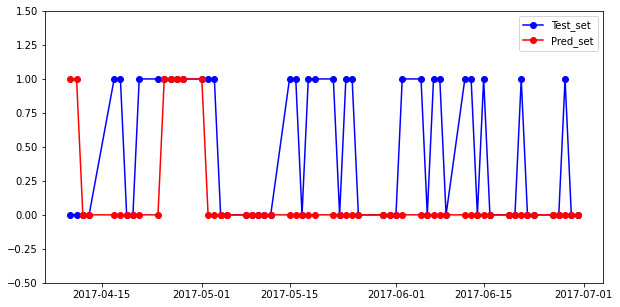

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(Y_value_add['Y_test'], '-bo')
plt.plot(Y_value_add['Y_pred'], '-ro')
plt.legend(['Test_set', 'Pred_set'])

# x_min = datetime(2021, 12, 1)
# x_max = datetime(2022, 2, 25)
# plt.xlim(x_min, x_max)
plt.ylim(-0.5, 1.5)

print("정답(Test_set)과 예측 결과(Pred_set)")
plt.show()

In [32]:
Y_value_add['check'] = (Y_value_add['Y_test'] == Y_value_add['Y_pred'])
True_counts, False_counts = Y_value_add['check'].value_counts()
# print(True_counts)
print(True_counts)

34


In [33]:
Y_value_add['check'].value_counts()

True     34
False    24
Name: check, dtype: int64

In [34]:
# Test set을 이용한 정답율(Accuracy) 계산 결과 (220222)

print("Accuracy with Test set : {:.2f}".format(True_counts/len(Y_value_add)*100))

Accuracy with Test set : 58.62


In [35]:
from sklearn.metrics import classification_report

report = classification_report(Y_value_add['Y_test'], Y_value_add['Y_pred'])

print(report)

              precision    recall  f1-score   support

           0       0.57      0.94      0.71        31
           1       0.71      0.19      0.29        27

    accuracy                           0.59        58
   macro avg       0.64      0.56      0.50        58
weighted avg       0.64      0.59      0.51        58



In [36]:
from sklearn.metrics import confusion_matrix
import math

cm = confusion_matrix(Y_value_add['Y_test'], Y_value_add['Y_pred'])

tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]

if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1

TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)

mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))), 3)

print("TN : ", tn)
print("FN : ", fn)
print("TP : ", tp)
print("FP : ", fp)
print("TPR : ", TPR)
print("FPR : ", FPR)
print("accuracy :", accuracy)
print("specitivity :", specitivity)
print("sensitivity :", sensitivity)
print("mcc :", mcc)

TN :  29
FN :  22
TP :  5
FP :  2
TPR :  0.18518518518518517
FPR :  0.06451612903225806
accuracy : 0.586
specitivity : 0.935
sensitivity : 0.185
mcc : 0.185


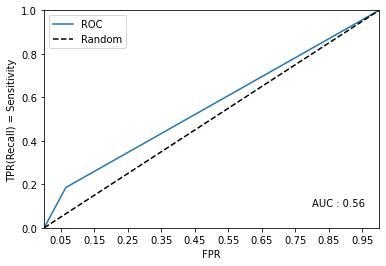

In [62]:
# ROC 곡선 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import roc_curve, roc_auc_score

# ROC 그래프 작성 함수
def roc_curve_plot(y_test, y_pred):

    # FPR = FP/(FP+TN)
    # TPR = Recall = TP/(TP + FN)
    
    fprs, tprs, thresholds = roc_curve(y_test, y_pred)
    roc_score= roc_auc_score(y_test, y_pred)

    # print(fprs, tprs)
    # fprs = [0, FPR, 1]          # roc_curve 함수의 반환 값 확인(220226)
    # tprs = [0, sensitivity, 1]
    
    # ROC 그래프 작성
    plt.plot(fprs, tprs, label='ROC')
    # 대각선 직선
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR'); plt.ylabel('TPR(Recall) = Sensitivity')
    
    plt.text(0.8, 0.1,'AUC : {:.2f}'.format(roc_score))
    plt.legend()

# 함수 호출 및 ROC 그래프 작성   
roc_curve_plot(Y_value_add['Y_test'], Y_value_add['Y_pred'])